In [1]:
import sys
sys.path.insert(0, '..')

%load_ext extensible_provn.prov_magics
import extensible_provn.view.prov_dictionary

3


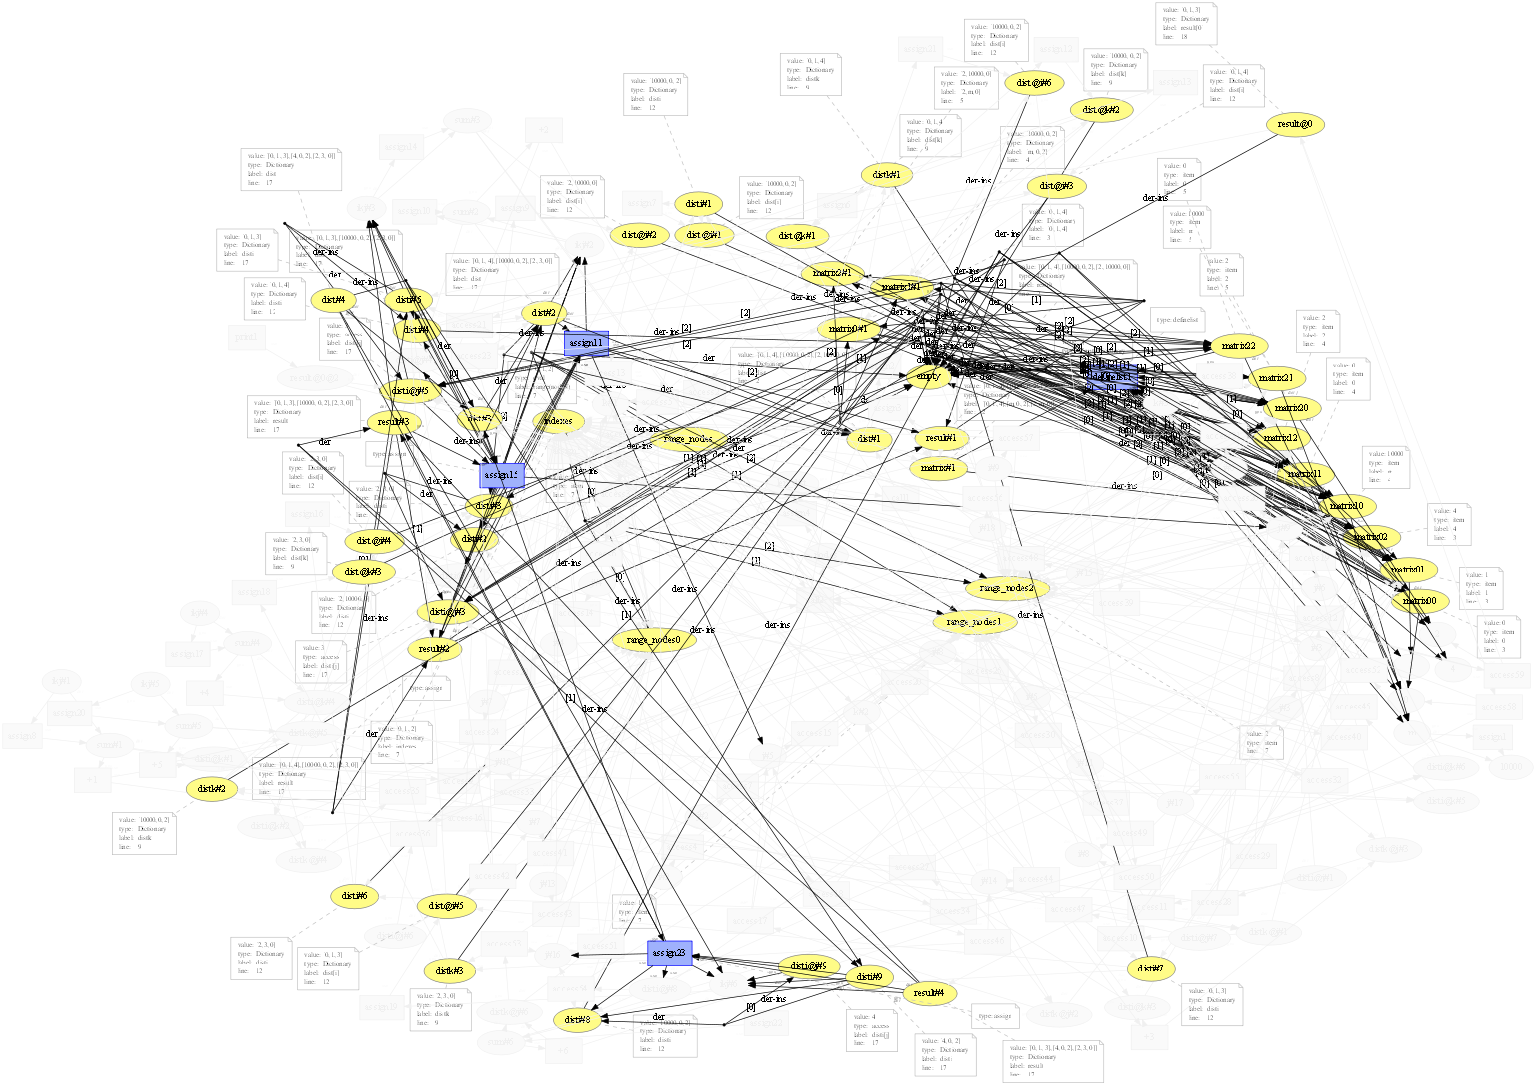

In [2]:
import importlib
import scripts.annotations as prov
importlib.reload(prov)
%run ../scripts/dic_floydwarshall.py